# Generar y analizar distintos tipos de ruido 

## Tipos de ruido
Ruído sal y pimienta: se caracteriza por una distribución aleatoria de píxeles blancos y negros (fallo del sensor a nivel de pixel).

Ruido Gausiano: el ruido Gaussiano muestra una densidad de probabilidad que responde a una distribución normal (o distribución de Gauss). Si un ruido es Gaussiano, la probabilidad que se aleje de más de 3σ del valor promedio es muy baja. Está asociado con la radiación electromagnética.

Ruido Impulsivo: El ruido impulsivo es aquel ruido cuya intensidad aumenta bruscamente durante un impulso. La duración de este impulso es breve en comparación con el tiempo que transcurre entre un impulso y otro. Es similar al ruido sal y pimienta pero, en general, no tendría por qué saturar el valor de los pixeles.

Ruido Speckle (multiplicativo): https://en.wikipedia.org/wiki/Speckle_noise 
Speckle is a granular 'noise' that inherently exists in and degrades the quality of the active radar, synthetic aperture radar (SAR), medical ultrasound and optical coherence tomography images.
The vast majority of surfaces, synthetic or natural, are extremely rough on the scale of the wavelength. Images obtained from these surfaces by coherent imaging systems such as laser, SAR, and ultrasound suffer from a common phenomenon called speckle. Speckle, in both cases, is primarily due to the interference of the returning wave at the transducer aperture. The origin of this noise is seen if we model our reflectivity function as an array of scatterers. Because of the finite resolution, at any time we are receiving from a distribution of scatterers within the resolution cell. These scattered signals add coherently; that is, they add constructively and destructively depending on the relative phases of each scattered waveform. Speckle noise results from these patterns of constructive and destructive interference shown as bright and dark dots in the image.

Ruido Poisson: https://en.wikipedia.org/wiki/Image_noise#Shot_noise   
The dominant noise in the darker parts of an image from an image sensor is typically that caused by statistical quantum fluctuations, that is, variation in the number of photons sensed at a given exposure level. This noise is known as photon shot noise. Shot noise has a root-mean-square value proportional to the square root of the image intensity, and the noises at different pixels are independent of one another. Shot noise follows a Poisson distribution, which except at very low intensity levels approximates a Gaussian distribution. 

Ruido aditivo periódico: https://en.wikipedia.org/wiki/Image_noise#Periodic_noise 
A common source of periodic noise in an image is from electrical or electromechanical interference during the image capturing process. An image affected by periodic noise will look like a repeating pattern has been added on top of the original image. In the frequency domain this type of noise can be seen as discrete spikes.



Tutorial "operations with images": https://docs.opencv.org/3.4/d5/d98/tutorial_mat_operations.html




## Función principal:

def noisy(noise_typ,image,params):  

Parameters:
    image : ndarray
        Input image data. It will be converted to float in the range [0,1].
        Implemented for 1 and N channels
    mode : str
        One of the following strings, selecting the type of noise to add:

        'gauss'     Gaussian-distributed additive noise.
        'poisson'   Poisson-distributed noise generated from the data.
        's&p'       Salt and Pepper. It replaces random pixels with 0 or 1.
        'speckle'   Multiplicative noise using noisy = image + n*image, where 
                    n is uniform noise with specified mean & variance.
        'add_per'   Additive periodic noise  
        'spatial'   Additive noise using the expression noisy = image + wG*Gn + wR*Rn,
                    where wG and wR are weights, Gn is a spatial gauss bell and Rn is
                    white noise.
    params: tuple. This params are mode specific. See the code bellow.


## ### CONFIGURAR PATH DE LA IMAGEN #####

In [9]:
## ### CONFIGURAR PATH DE LA IMAGEN #####

imagePath="imagenes/FL_s00082_21.png"
print("\n imagePath = ", imagePath, "\n")


 imagePath =  imagenes/FL_s00082_21.png 



In [10]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

%matplotlib inline



In [11]:
def normalizar(I):
    return (I - I.min()) / (I.max()-I.min())

In [12]:
def acumulado(image):
    step = 1/256.0
    h=np.zeros(256,np.float32)
    for i in range(1,256):
        h[i] = sum(np.float64(image)<=i*step) 
    #print(h) 
    return h

In [13]:
def compareHistograms(I1,I2,title1,title2):
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.hist(I1.ravel(),256,[0,1]) 
    plt.title(title1)
    plt.ylabel('N')
    plt.xlabel('intensity')
    #plt.show()
    #plt.pause(1)
    
    plt.subplot(2, 1, 2)
    plt.hist(I2.ravel(),256,[0,1]) 
    plt.title(title2)
    plt.ylabel('N')
    plt.xlabel('intensity')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    
    plt.show()
    plt.pause(1)


In [14]:
def noisy(noise_typ,image,params):    
    
   if np.size(image.shape)==2:
       ch = 1
       row,col= image.shape
   else:
       row,col,ch= image.shape
    
   # definiciones de cada tipo de ruido.  
   if noise_typ == "gauss":
      mean = params[0]
      var = params[1]
      
      sigma = var**0.5
      if ch == 1:
          gauss = np.random.normal(mean,sigma,(row,col))
      else:  
          gauss = np.random.normal(mean,sigma,(row,col,ch))
          
      #gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss   # ruido aditivo
      return noisy

   elif noise_typ == "s&p":
      s_vs_p = params[0] 
      amount = params[1]
      noisy = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]      
      noisy[tuple(coords)] = 1
      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
      noisy[tuple(coords)] = 0
      return noisy    
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)

      # tres maneras de calcular el histograma: mediante función propia (aproximada), con opencv o con matplotlib.pyplot
      # para que se visualice la figura mientras se está depurando, es preciso meterle una pausa al sistema para que se actualice
      #      acc = acumulado(noisy)
      #      h = acc[1:] - acc[0:-1]
      #      plt.figure()
      #      plt.plot( arange(0,255) , h)
      #      plt.draw()
      #      plt.pause(0.1)
      #      
      #      hist2 = cv2.calcHist([noisy.astype('float32')],[0],None,[256],[0,1])
      #      plt.figure()
      #      plt.plot(arange(0,256),hist2)
      #      plt.draw()
      #      plt.pause(1)
      #      plt.pause(0.0001)
      #            
      #      plt.figure()
      #      plt.hist(noisy.ravel(),256,[0,1]) 
      #      plt.show()
      #      plt.pause(1)     
      return noisy

   elif noise_typ =="speckle":  
      mean = params[0]  
      var = params[1] 
      sigma = var**0.5
      if ch == 1:
          gauss = np.random.normal(mean,sigma,(row,col))
      else:  
          gauss = np.random.normal(mean,sigma,(row,col,ch))
      noisy = image + image * gauss
      return noisy

   elif noise_typ =="add_per":  
      # ruido horizontal:
      pattern = np.zeros(image.shape)     
      numBars = params[0] 
      nivel= (params[1], params[2])
      step = int(np.floor(image.shape[0]/numBars))     
      for i in range(0,numBars+1):
          if i%2:
              pattern[i*step:min((i+1)*step,image.shape[0]), :] = nivel[0]
          else:
              pattern[i*step:min((i+1)*step,image.shape[0]), :] = nivel[1]
      noisy = image + pattern
      return noisy  
    
   elif noise_typ =="spatial":      
    
        sigma = params[0]  # 50  #; %150;
        pesoG = params[1]  
        pesoR = params[2]  

        vx=np.arange(0,col)
        x = np.repeat(vx[np.newaxis,:], row, 0) - round(col/2)               
        vy=np.arange(0,row)
        y = np.repeat(vy[:,np.newaxis], col, 1) - round(row/2)               

        P = -( (x)**2 + (y)**2 )   /   (2*sigma**2)                
        G = (1/2*np.pi*sigma)*np.exp(P) 
        Gn = normalizar(G)        
        #cv2.imshow("Gnorm", Gnorm)
        #key = cv2.waitKey(1)
        if ch == 1:
            Rn = np.random.uniform(0,1,(row,col))
        else:  
            Rn = np.random.uniform(0,1,(row,col,ch))
        #cv2.imshow("R", R)
        #key = cv2.waitKey(1)
        noisy = normalizar(image + 0.3*Gn + 0.1*Rn)       
        #cv2.imshow("noisy", noisy)
        #key = cv2.waitKey(1)
        return noisy, Gn, Rn

Secciones de la práctica:
----


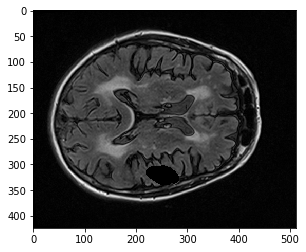

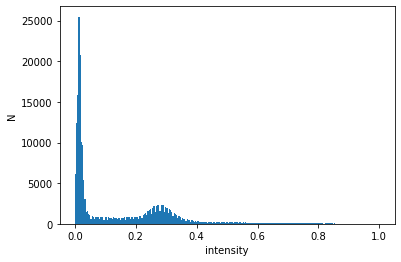

In [15]:
# cargar imagen de fichero
image0 = cv2.imread(imagePath,0)

# visualizarla con matplotlib inline
plt.imshow(image0, cmap='gray')

# visualizarla con openCV
cv2.imshow("orig",image0)
key = cv2.waitKey(20) 

# normalizar la imagen al rango [0,1] de tipo float para facilitar las operaciones
image = image0.astype(np.float32)
imageN = normalizar(image)   #(image-image.min()) / (image.max()-image.min()) 

plt.figure()
plt.hist(imageN.ravel(),256,[0,1]) 
plt.ylabel('N')
plt.xlabel('intensity')
plt.show()
plt.pause(1)
    
    


En el histograma de la imagen original se aprecia que hay una gran cantidad de pixeles cercanos al cero (ver pico),  una cantidad significativa de pixeles en [0.2,0.3] y algunos pixeles con valores superiores a 0.4 que están muy distribuidos.  

# 2.1 Ruido sal y pimienta

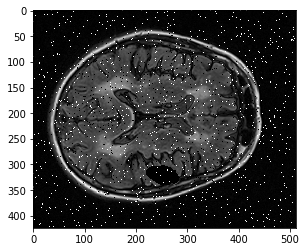

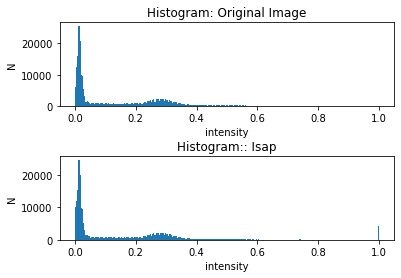

In [16]:
# 2.1 Ruido sal y pimienta
Isap = noisy("s&p",imageN, (0.5, 0.04))

plt.imshow(Isap, cmap='gray')
compareHistograms(imageN,Isap, "Histogram: Original Image", "Histogram:: Isap")

cv2.imshow("s&p",Isap)
key = cv2.waitKey(20)


El ruido sal y pimienta es bastante visible en la imagen original (en este caso, la "sal", porque la "pimienta" se confunde con el fondo). En el hostograma se aprecia un pico en "1".

# 2.2 Ruido gaussiano

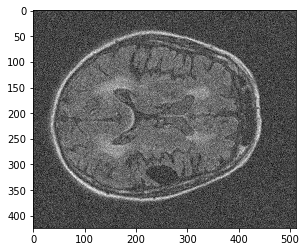

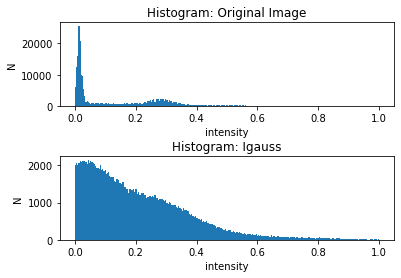

In [17]:
# 2.2 Ruido gaussiano
Igauss = noisy("gauss",imageN, (0,0.01))

plt.imshow(Igauss, cmap='gray')
compareHistograms(imageN,Igauss, "Histogram: Original Image", "Histogram: Igauss")

cv2.imshow("gauss",Igauss)
key = cv2.waitKey(20)


El ruido gaussiano corrompe la imagen de manera que el histograma deja de ser significativo cuando se aumenta el valor de la varianza. 

# 2.3 Ruido impulsivo
El ruido impulsivo es aquel ruido cuya intensidad aumenta bruscamente durante un impulso. La duración de este impulso es breve en comparación con el tiempo que transcurre entre un impulso y otro. Es similar al ruido sal y pimienta pero, en general, no tendría por qué saturar el valor de los píxeles.



# 2.4 Ruido speckle

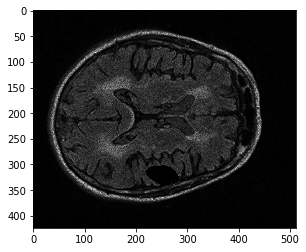

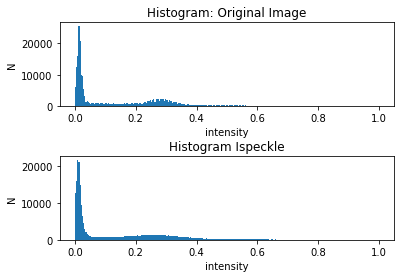

In [18]:
# 2.4 Ruido speckle
Ispeckle = noisy("speckle",imageN, (0, 0.05))

plt.imshow(Ispeckle, cmap='gray')
compareHistograms(imageN,Ispeckle, "Histogram: Original Image", "Histogram Ispeckle")

cv2.imshow("speckle",Ispeckle)
key = cv2.waitKey(20)


# 2.5 Ruido Poisson

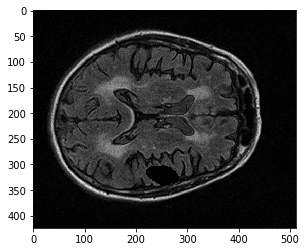

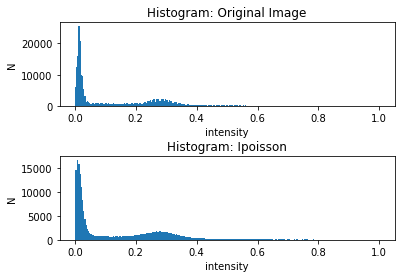

In [19]:
# 2.5 Ruido Poisson
Ipoisson = noisy("poisson",imageN, 0) 

plt.imshow(Ipoisson, cmap='gray')
compareHistograms(imageN,Ipoisson, "Histogram: Original Image", "Histogram: Ipoisson")

cv2.imshow("poisson",Ipoisson)
key = cv2.waitKey(20)


# 2.6 Ruido aditivo periódico

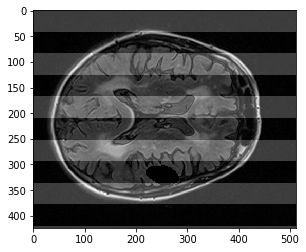

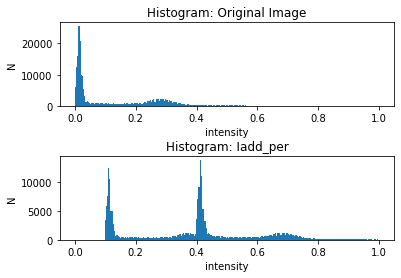

In [20]:
# 2.6 Ruido aditivo periódico
Iadd_per = noisy("add_per", imageN, (10, .10, .40)) 
cv2.imshow("Iadd_per",Iadd_per)
key = cv2.waitKey(20)
plt.imshow(Iadd_per, cmap='gray')
compareHistograms(imageN,Iadd_per, "Histogram: Original Image", "Histogram: Iadd_per")

Obsérvese cómo se repite el histograma inicial para los dos valores del ruido periódico añadido (se aprecian pequeñas variaciones porque el histograma original se calcula sobre toda la imagen y éste se divide en dos grupos de pixeles en cada periodo). La adición de una constante conlleva una traslación del histograma. 

# 2.7 Ruido espacial

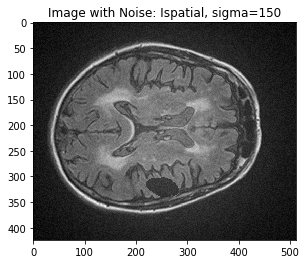

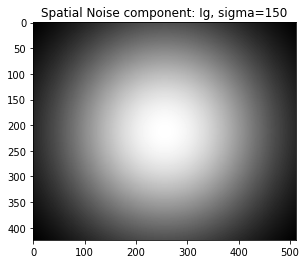

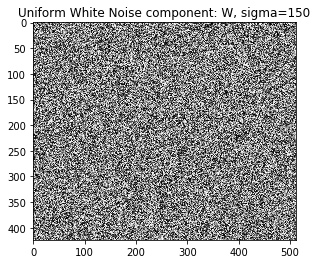

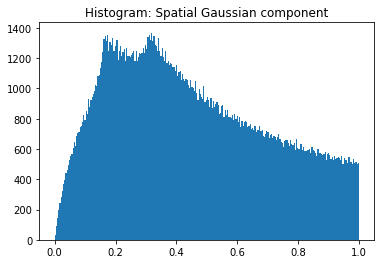

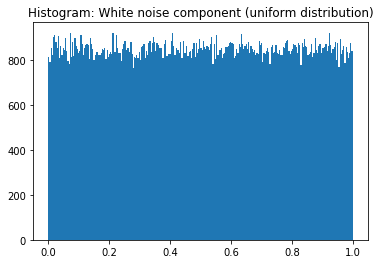

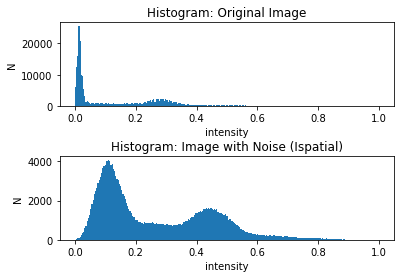

In [21]:
# 2.7 Ruido espacial
Ispatial, Ig, W = noisy("spatial",imageN, (150,0.3,0.1)) 

plt.imshow(Ispatial, cmap='gray')
plt.title("Image with Noise: Ispatial, sigma=150")
plt.show()
plt.imshow(Ig, cmap='gray')
plt.title("Spatial Noise component: Ig, sigma=150")
plt.show()
plt.imshow(W, cmap='gray')
plt.title("Uniform White Noise component: W, sigma=150")
plt.show()
plt.hist(Ig.ravel(),256,[0,1]) 
plt.title("Histogram: Spatial Gaussian component")
plt.show()
plt.hist(W.ravel(),256,[0,1]) 
plt.title("Histogram: White noise component (uniform distribution)")
plt.show()
plt.pause(1)

compareHistograms(imageN,Ispatial, "Histogram: Original Image", "Histogram: Image with Noise (Ispatial)")

cv2.imshow("Ispatial",Ispatial)
key = cv2.waitKey(20)

# 2.8 Ruido espacial

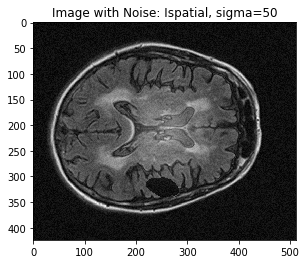

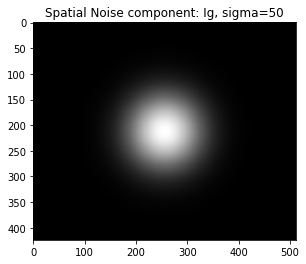

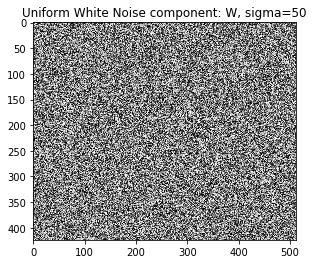

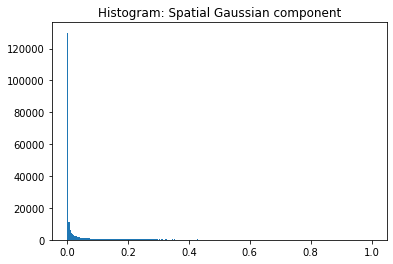

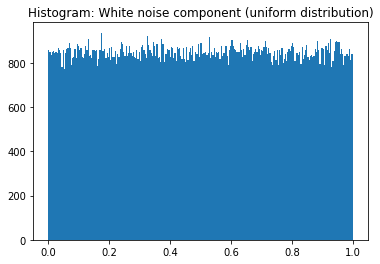

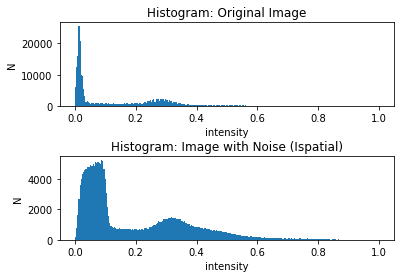

In [22]:
# 2.8 Ruido espacial
sigma=50

Ispatial, Ig, W = noisy("spatial",imageN, (sigma,0.3,0.1)) 

plt.imshow(Ispatial, cmap='gray')
plt.title("Image with Noise: Ispatial, sigma=50")
plt.show()
plt.imshow(Ig, cmap='gray')
plt.title("Spatial Noise component: Ig, sigma=50")
plt.show()
plt.imshow(W, cmap='gray')
plt.title("Uniform White Noise component: W, sigma=50")
plt.show()

plt.hist(Ig.ravel(),256,[0,1]) 
plt.title("Histogram: Spatial Gaussian component")
plt.show()

plt.hist(W.ravel(),256,[0,1]) 
plt.title("Histogram: White noise component (uniform distribution)")
plt.show()
plt.pause(1)

compareHistograms(imageN,Ispatial, "Histogram: Original Image", "Histogram: Image with Noise (Ispatial)")

cv2.imshow("Ispatial",Ispatial)
key = cv2.waitKey(20)



# 2.9 Compare ambos los resultados de 2.7 y 2.8.

Es conveniente realizar en análisis en el dominio de la imagen y también en el histograma. No entramos en el dominio de la frecuencia.

En el dominio de la imagen:
- la componente espacial está más concentrada en 2.8 que 2.7. Esto se aprecia en un mayor aclarado en el centro de la imagen en 2.8.   
- el ruido aleatorio con distribución uniforme no se aprecia porque su contribución es muy pequeña (10% de variación en la intensidad)

# 2.10- Explique cómo diseñaría un filtro para corregir el ruido del tipo del apartado 2.8. 

Como el ruido en el apartado 2.8 se ha generado utilizando dos componentes independientes, lo más sencillo es definir un filtro para cada tipo de ruido. En este caso, la componente aleatoria se puede eliminar utilizando filtros que eliminen las altas frecuencias y mantengan los bordes, como el filtro de gaussiana o el filtro de mediana. Para la componente espacial, sabemos que tiene una forma gaussiana 2D (campana, distribución normal). Sería necesario analizar las componentes de baja frecuencia de la señal para estimar el filtro óptimo. Sin embargo, si esto no fuera posible, podría ser suficiente con estimar groseramente la amplitud de la campana y filtrar las componentes que tienen una frecuencia superior a ésta. Por ejemplo, mediante un filtrado morfológico se pueden detectar las componentes de baja frecuencia y después restárselas a la señal de entrada (Top Hat = Input image - Opening image).


# Impleméntelo.




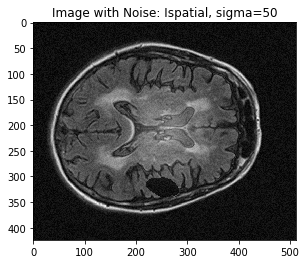

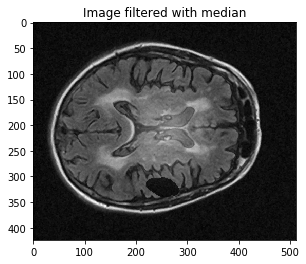

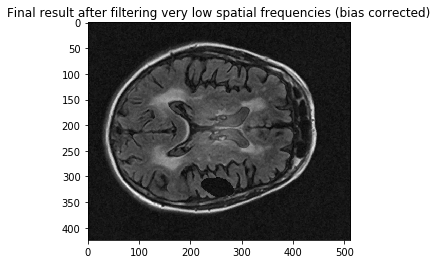

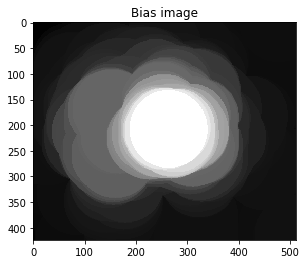

In [23]:
Ispatial
plt.imshow(Ispatial, cmap='gray')
plt.title("Image with Noise: Ispatial, sigma=50")
plt.show()

Ifiltmedian = cv2.medianBlur(Ispatial.astype(np.float32), 3)

plt.imshow(Ifiltmedian, cmap='gray')
plt.title("Image filtered with median")
plt.show()
#cv2.imshow("Ifiltmedian",Ifiltmedian)
#key = cv2.waitKey(1)

Ibiascorrected = cv2.morphologyEx( Ifiltmedian, cv2.MORPH_TOPHAT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (150,150)) )

plt.imshow(Ibiascorrected, cmap='gray')
plt.title("Final result after filtering very low spatial frequencies (bias corrected)")
plt.show()
#cv2.imshow("Ibiascorrected",Ibiascorrected)
#key = cv2.waitKey(1)

plt.imshow(Ifiltmedian - Ibiascorrected, cmap='gray')
plt.title("Bias image")
plt.show()
#cv2.imshow("Bias image",Ifiltmedian - Ibiascorrected)
#key = cv2.waitKey(1)



Como se puede apreciar, el resultado final tiene menos intensidad que el original, por lo que convendría volver a normalizar entre 0 y 1. 

Obsérvese también que el valor de intensidad mínimo es negativo (esto hay que tenerlo en cuenta, por ejemplo, eliminando las intensidades negativas o subiendo el valor de intensidad). 

El resultado obtenido mantiene la forma del histograma, pero no los niveles de intensidad. Para muchas aplicaciones esto es suficiente.


rango de la imagen =  -0.04028497 0.91394997


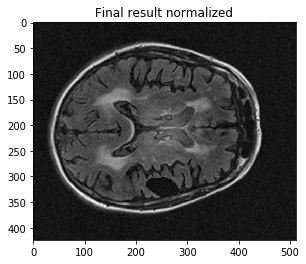

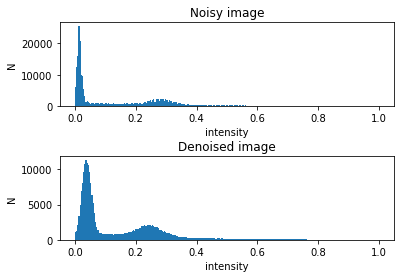

In [24]:
print("rango de la imagen = ", Ibiascorrected.min(), Ibiascorrected.max())



plt.imshow(normalizar(Ibiascorrected), cmap='gray')
plt.title("Final result normalized")
plt.show()

compareHistograms(imageN, Ibiascorrected, "Noisy image","Denoised image")


In [25]:
#plt.close("all")
# para limpiar Ventanas de OpenCV, descomentar siguiente línea
cv2.destroyAllWindows() 
